<a href="https://colab.research.google.com/github/shubhamphal/One-NLP/blob/master/Poetry_Generation_using_Language_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

In [4]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [5]:
!wget nlp.stanford.edu/data/glove.6B.zip

--2020-12-02 18:31:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-02 18:31:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-02 18:31:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [6]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [7]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 200  #Increase the number of epochs to 2000 or greater for better results
LATENT_DIM = 25

In [8]:
input_texts=[]
target_texts=[]

for line in open('robert_frost.txt'):
  line =line.rstrip()
  if not line:
    continue
  input_line='<sos> '+line
  target_line=line+' <eos>'
  input_texts.append(input_line)
  target_texts.append(target_line)

In [9]:
all_lines=input_texts+target_texts

In [10]:
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE,filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences=tokenizer.texts_to_sequences(input_texts)
target_sequences=tokenizer.texts_to_sequences(target_texts)

In [11]:
max_sequence_length=max(len(s) for s in input_sequences)
print("Max sequence length ",max_sequence_length)

Max sequence length  12


In [12]:
word2idx=tokenizer.word_index
print(len(word2idx))

3056


In [13]:
assert('<sos>' in word2idx)

In [14]:
max_sequence_length=max(max_sequence_length,MAX_SEQUENCE_LENGTH)
input_sequences=pad_sequences(input_sequences,maxlen=max_sequence_length,padding='post')
target_sequences=pad_sequences(target_sequences,maxlen=max_sequence_length,padding='post')

In [15]:
f=open(os.path.join('.','glove.6B.%sd.txt'%EMBEDDING_DIM))

In [16]:
word2vec={}
for line in f:
  values=line.split()
  word=values[0]
  vec=np.asarray(values[1:],dtype='float32')
  word2vec[word]=vec

In [17]:
num_words=min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix=np.random.randn(num_words,EMBEDDING_DIM)*0.1
for word, i in word2idx.items():
  if i<MAX_VOCAB_SIZE:
    emb_vector=word2vec.get(word)
    if emb_vector is None:
      continue
    else:
      embedding_matrix[i]=emb_vector

In [18]:
one_hot_targets=np.zeros((len(input_sequences),max_sequence_length,num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word>0:
      one_hot_targets[i,t,word]=1


In [19]:
one_hot_targets.shape

(1436, 100, 3000)

In [20]:
embedding_matrix.shape

(3000, 50)

In [21]:
embedding_layer=Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix])

In [22]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
initial_h=Input(shape=(LATENT_DIM,))
initial_c=Input(shape=(LATENT_DIM,))
x=embedding_layer(input_)
lstm=LSTM(LATENT_DIM,return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h,initial_c])
dense=Dense(num_words,activation='softmax')
output=dense(x)
model=Model([input_,initial_h,initial_c],output)

In [23]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)

In [24]:
z=np.zeros(shape=(len(input_sequences),LATENT_DIM))

In [25]:
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/200
9/9 [==============================] - 14s 2s/step - loss: 0.6524 - accuracy: 0.0013 - val_loss: 0.6160 - val_accuracy: 0.0015
Epoch 2/200
9/9 [==============================] - 14s 2s/step - loss: 0.5626 - accuracy: 0.0024 - val_loss: 0.5775 - val_accuracy: 0.0027
Epoch 3/200
9/9 [==============================] - 14s 2s/step - loss: 0.5279 - accuracy: 0.0086 - val_loss: 0.5888 - val_accuracy: 0.0100
Epoch 4/200
9/9 [==============================] - 14s 2s/step - loss: 0.5211 - accuracy: 0.0100 - val_loss: 0.5907 - val_accuracy: 0.0100
Epoch 5/200
9/9 [==============================] - 14s 2s/step - loss: 0.5160 - accuracy: 0.0100 - val_loss: 0.5968 - val_accuracy: 0.0100
Epoch 6/200
9/9 [==============================] - 14s 2s/step - loss: 0.5138 - accuracy: 0.0100 - val_loss: 0.5983 - val_accuracy: 0.0100
Epoch 7/200
9/9 [==============================] - 14s 2s/step - loss: 0.5103 - accuracy: 0.0100 - val_loss: 0.5944 - val_accuracy: 0.0100
Epoch 8/200
9/9 [==========

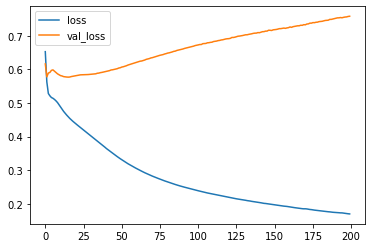

In [26]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

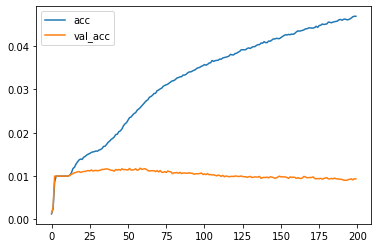

In [27]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [28]:
input2=Input(shape=(1,))
x=embedding_layer(input2)
x, h, c=lstm(x, initial_state=[initial_h,initial_c])
output2=dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [29]:
idx2word = {v:k for k, v in word2idx.items()}

In [30]:
def sample_line():
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))
  eos = word2idx['<eos>']
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [31]:
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("generate another? [Y/n]")
  if ans and ans[0].lower().startswith('n'):
    break

of wire with furs to repented, but
to stop without a farm
over the january thaw
we ought and leaf, for those to the house,
generate another? [Y/n]n
